In [ ]:
%pip install qiskit==1.2.4
%pip install qiskit-aer==0.15.1
%pip install pylatexenc==2.10

In [1]:
# Utility functions

# A list of all bit strings of length n 

def bit_strings(n): 
    if n == 0: 
        return [ [] ]
    else:
        bs = bit_strings(n-1) 
        return list(map(lambda x: [0] + x, bs)) + list(map(lambda x: [1] + x, bs))

# A list of n zeroes with 1 in position m

def single_one(m,n): 
    x = [0] * n 
    x[m] = 1 
    return x 

# A list of n zeroes with -1 in position m

def single_minus_one(m,n): 
    x = [0] * n 
    x[m] = -1 
    return x 

# Working with n qubits, construct a unitary matrix from f 

def unitary_from_function(f,n):
    u = [] 
    bs = bit_strings(n) 
    for i in range(2**n):  
        if f(bs[i]) == 1:
            u = u + [single_minus_one(i,2**n)] 
        else:
            u = u + [single_one(i,2**n)] 
    return u 

w = [1, 1]

def f(x):
    if x == w:
        return 1 
    else: 
        return 0 

# The Grover diffusion matrix for n qubits

def grover_row(r,n):
    N = 2**n 
    row = []
    for i in range(r):
        row = row + [2.0/N] 
    row = row + [2.0/N - 1] 
    for i in range(r+1,N): 
        row = row + [2.0/N] 
    return row

def grover_diffusion(n):
    N = 2**n 
    g = []  
    for i in range(N):
        g = g + [grover_row(i,n)]
    return g 

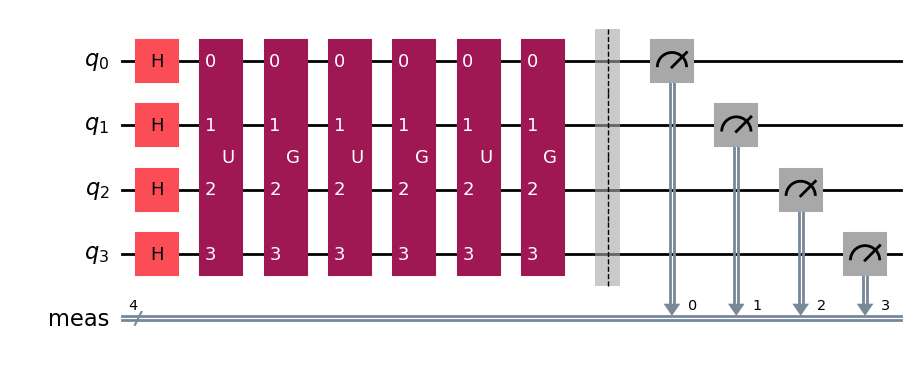

In [2]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_gate
from qiskit.visualization import array_to_latex
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector
from qiskit import transpile 
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit import ControlledGate
import math 

# Grover's algorithm with a parameteric construction of the circuit

# Given a function f : {0,1}^n -> {0,1} such that for some input vector w,
# f(w) = 1 and for all x != w, f(x) = 0.
# The problem is to find w.

# Define the number of qubits

n = 4 

# Define f by setting the value of w

w = [0, 1, 0, 0] # length must be equal to n

def f(x):
    if x == w:
        return 1 
    else: 
        return 0 

# Construct U which has -1 in the correct position on the diagonal

U = Operator(unitary_from_function(f,n))

# Now construct the Grover diffusion operator

G = Operator(grover_diffusion(n)) 

# Build a circuit with the correct number of iterations, i.e. the closest integer to pi sqrt(2**n) / 4

r = round(math.pi * math.sqrt(2**n) / 4) 

grover = QuantumCircuit(n) 

# To get the initial state, apply H to every qubit

for i in range(n): 
    grover.h(i) 

# Repeatedly apply U then G

for i in range(r): 
    grover.unitary(U,range(n),label="U")
    grover.unitary(G,range(n),label="G")

# What if we do too many iterations?
# Try putting some extra iterations into the circuit to see the effect.


# Also see what happens if there are not enough iterations.

# Also try more qubits. How many can qBraid handle?

# Measure all the qubits - to do that, we don't need to introduce classical bits, they are defined automatically

grover.measure_all() 

# Check the circuit

grover.draw("mpl")

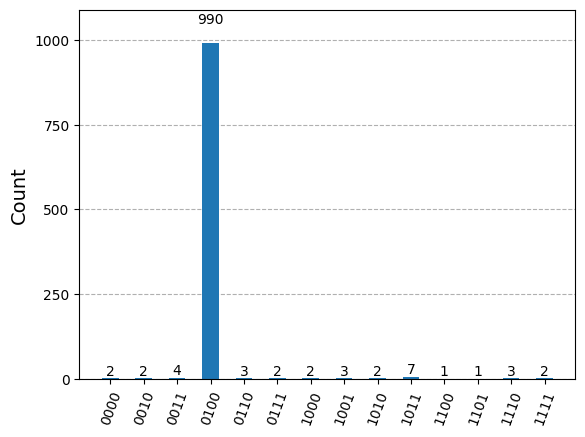

In [3]:
# Simulate and plot results

backend = BasicSimulator()
compiled = transpile(grover, backend)
job_sim = backend.run(compiled, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(compiled)
plot_histogram(counts)